In [ ]:
import pandas as pd
import numpy as np

### Считываем датасет из excel

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ts_data_students1.xlsx to ts_data_students1 (1).xlsx


In [ ]:
dfData = pd.read_excel(open('ts_data_students1.xlsx', 'rb'), sheet_name='final data', usecols='I')
dfTime = pd.read_excel(open('ts_data_students1.xlsx', 'rb'), sheet_name='final time', usecols='I')

In [ ]:
dfData = dfData.dropna()
dfTime = dfTime.dropna()

In [ ]:
dfTime['time']

0     2019-07-16 00:00:00
1     2019-07-16 01:00:00
2     2019-07-16 02:00:00
3     2019-07-16 03:00:00
4     2019-07-16 04:00:00
              ...        
194   2019-07-24 02:00:00
195   2019-07-24 03:00:00
196   2019-07-24 04:00:00
197   2019-07-24 05:00:00
198   2019-07-24 06:00:00
Name: time, Length: 199, dtype: datetime64[ns]

In [ ]:
dfData['data']

0      20267.318057
1      20283.745682
2      21705.595555
3      23587.441438
4      26500.463210
           ...     
194    29950.903288
195    32144.500021
196    36113.405210
197    35006.367066
198    33972.724810
Name: data, Length: 199, dtype: float64

In [ ]:
dfData.shape

(199, 1)

In [ ]:
dfTime1 =  pd.to_datetime(dfTime['time'], format='%Y-%b-%d %X')
dfTime1

0     2019-07-16 00:00:00
1     2019-07-16 01:00:00
2     2019-07-16 02:00:00
3     2019-07-16 03:00:00
4     2019-07-16 04:00:00
              ...        
194   2019-07-24 02:00:00
195   2019-07-24 03:00:00
196   2019-07-24 04:00:00
197   2019-07-24 05:00:00
198   2019-07-24 06:00:00
Name: time, Length: 199, dtype: datetime64[ns]

In [ ]:
data = [dfData["data"], dfTime["time"]]

headers = ["data", "time"]

df = pd.concat(data, axis=1, keys=headers)
df.head()

,data,time
0,20267.318057,2019-07-16 00:00:00
1,20283.745682,2019-07-16 01:00:00
2,21705.595555,2019-07-16 02:00:00
3,23587.441438,2019-07-16 03:00:00
4,26500.463210,2019-07-16 04:00:00


## Predicting with ARIMA


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

In [ ]:
train_df = df.loc[:150, :]
train_df.shape
train_df.head()

,data,time
0,20267.318057,2019-07-16 00:00:00
1,20283.745682,2019-07-16 01:00:00
2,21705.595555,2019-07-16 02:00:00
3,23587.441438,2019-07-16 03:00:00
4,26500.463210,2019-07-16 04:00:00


Dickey-Fuller test: p=0.000023


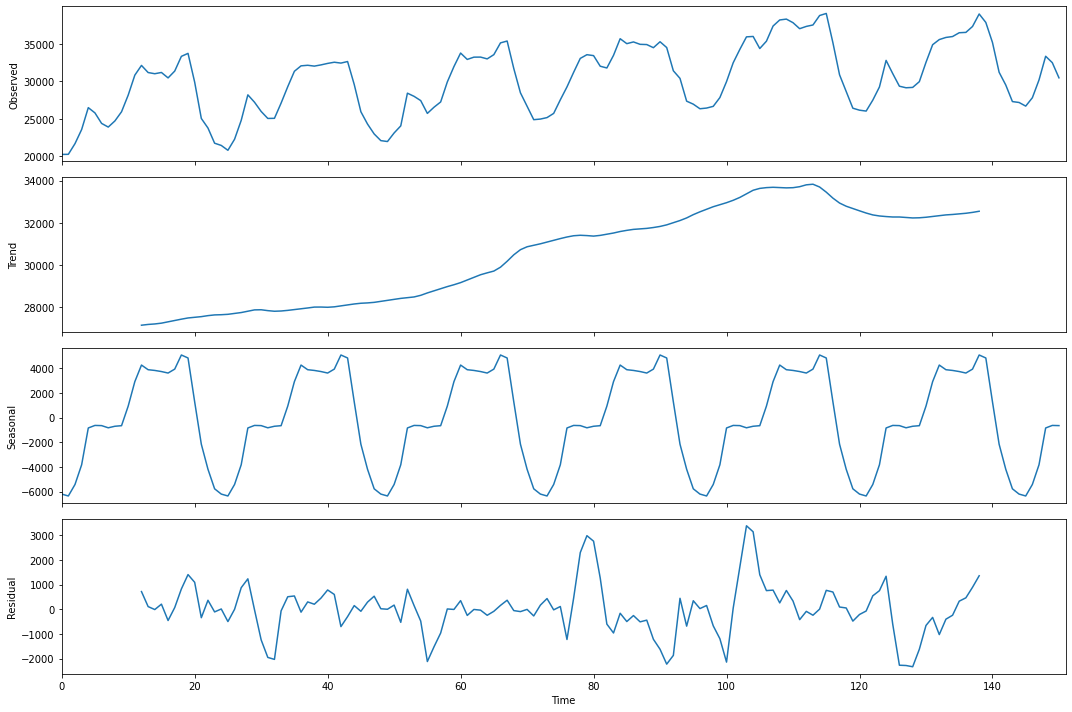

In [ ]:
sm.tsa.seasonal_decompose(train_df['data'].values, freq=24).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['data'])[1])

Видим, что p отлична от нуля и имеем выраженный тренд. Исходный ряд стационарным не является
Попробуем стабилизировать дисперсию преобразованием Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 1.278601
Dickey-Fuller test: p=0.000030


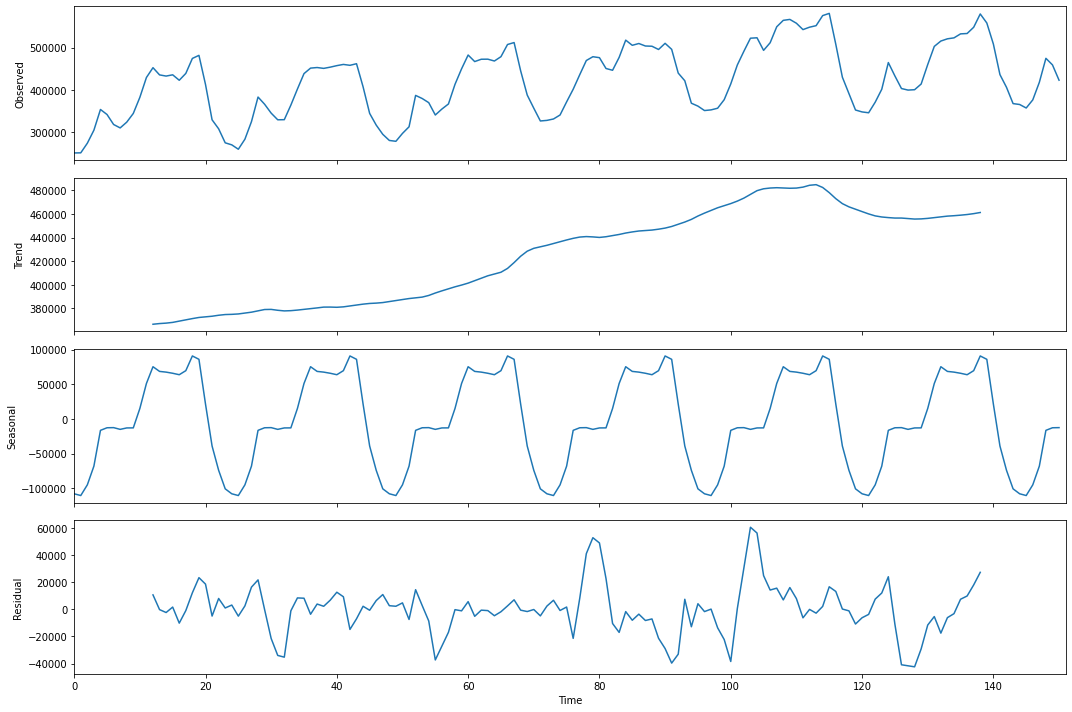

In [ ]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)


data = train_df.copy()
train_df["data_box"], lmbda = scipy.stats.boxcox(
    train_df.data
)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
sm.tsa.seasonal_decompose(train_df['data_box'].values, freq=24).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['data_box'])[1])

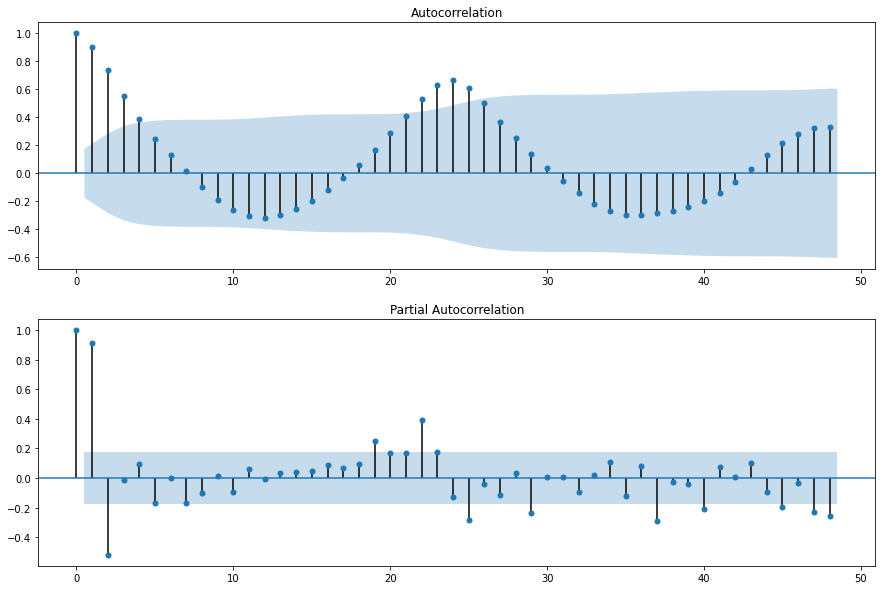

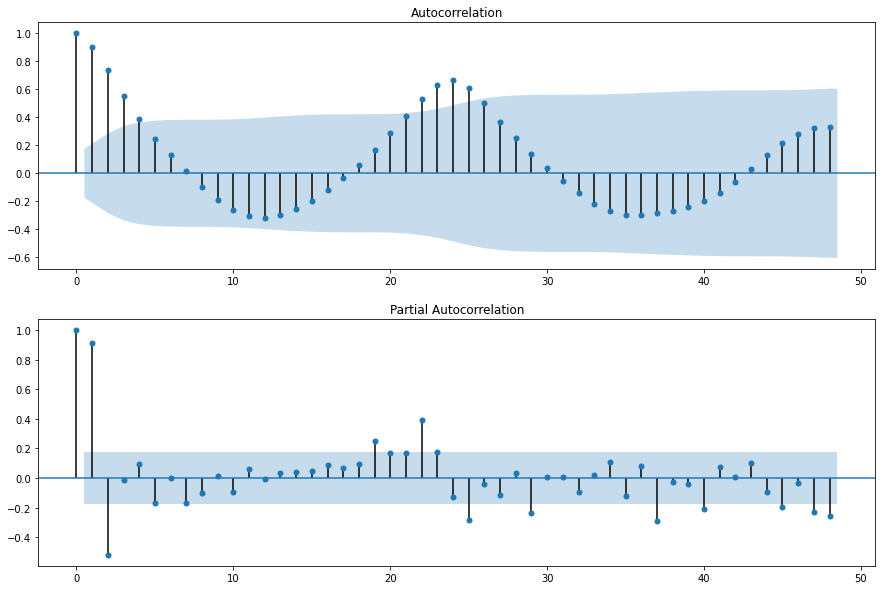

In [ ]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.data_box[25:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.data_box[25:].values.squeeze(), lags=48, ax=ax)

График автокорреляции говорит о сезонности, возьмем сезонную разность

Dickey-Fuller test: p=0.073589


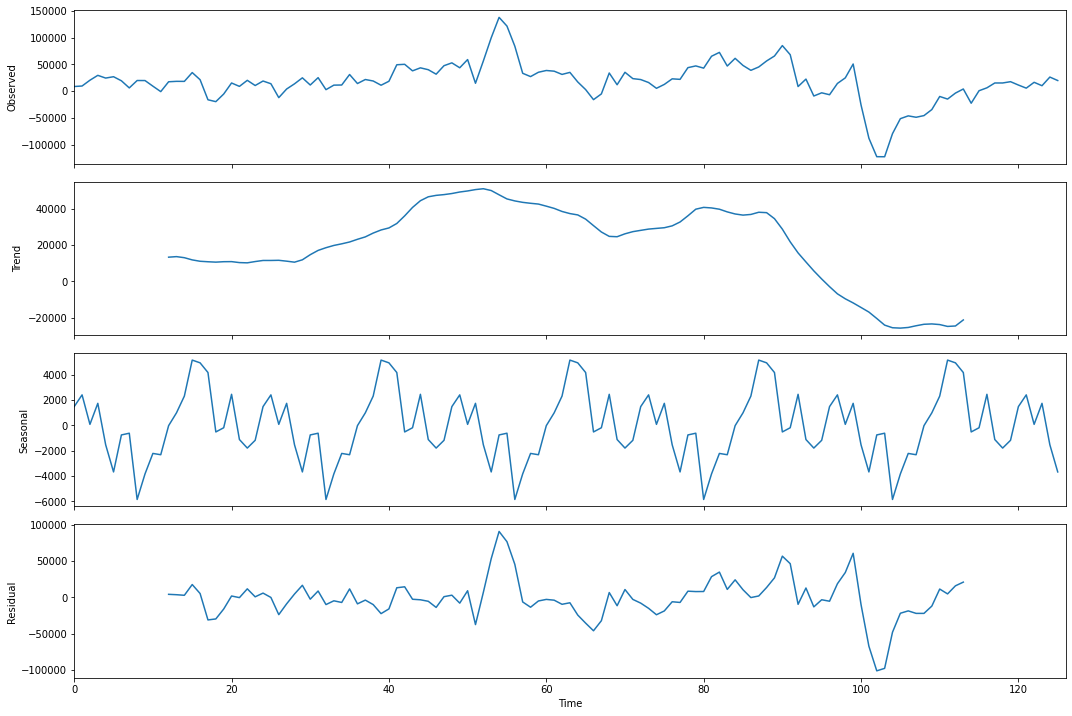

In [ ]:
train_df["data_box_season"] = train_df.data_box - train_df.data_box.shift(24)
sm.tsa.seasonal_decompose(train_df['data_box_season'][25:].values, freq=24).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['data_box_season'][25:])[1])

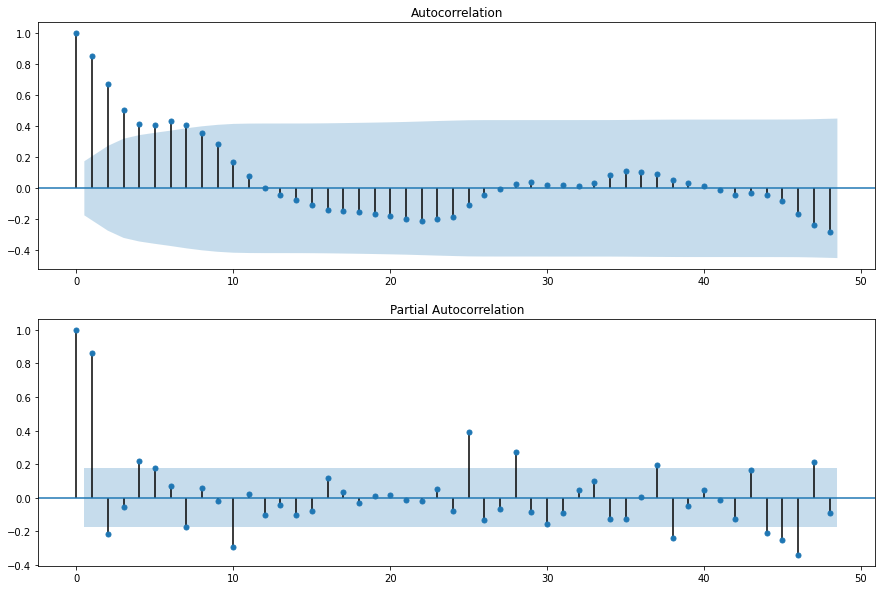

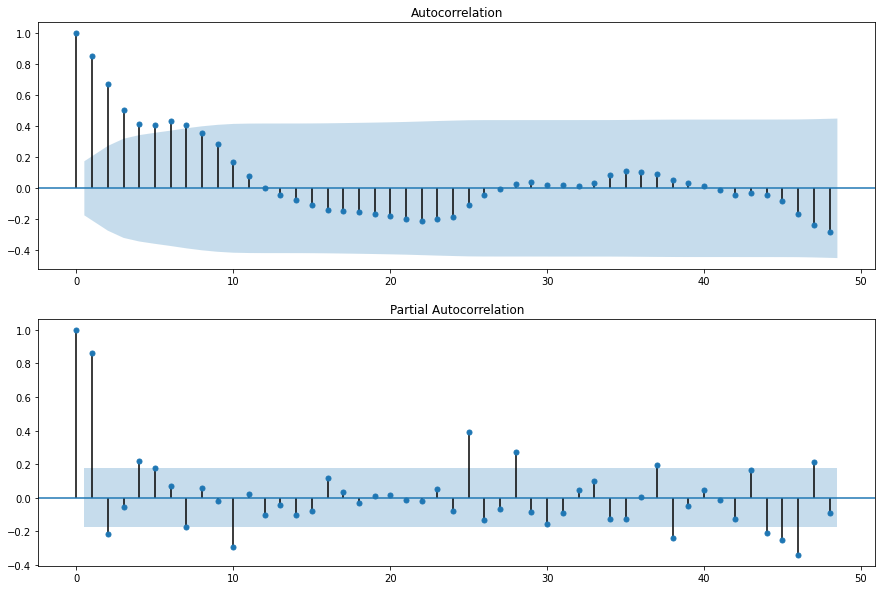

In [ ]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.data_box_season[25:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.data_box_season[25:].values.squeeze(), lags=48, ax=ax)

Так как на графике частной автокорреляционной функции значим лишь один лаг, стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

Dickey-Fuller test: p=0.000000


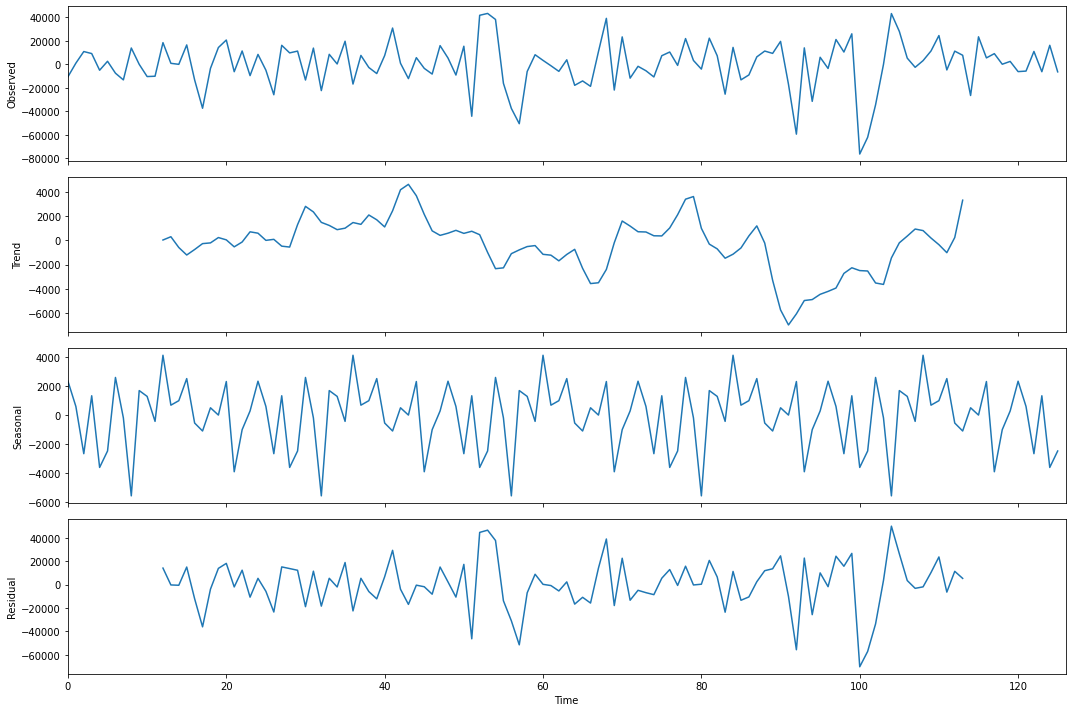

In [ ]:
train_df["data_box_season_diff"] = train_df.data_box_season - train_df.data_box_season.shift(1)
sm.tsa.seasonal_decompose(train_df['data_box_season_diff'][25:].values, freq=24).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['data_box_season_diff'][25:])[1])


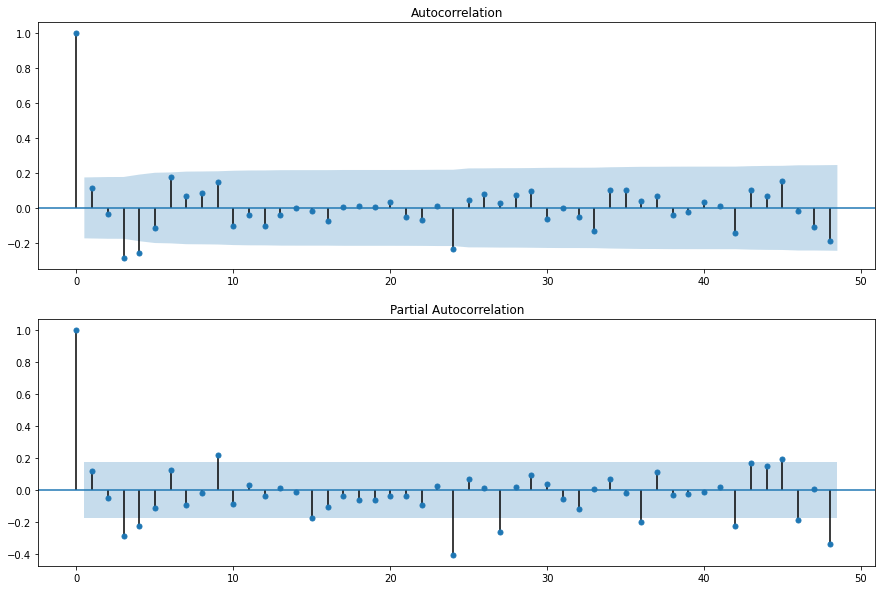

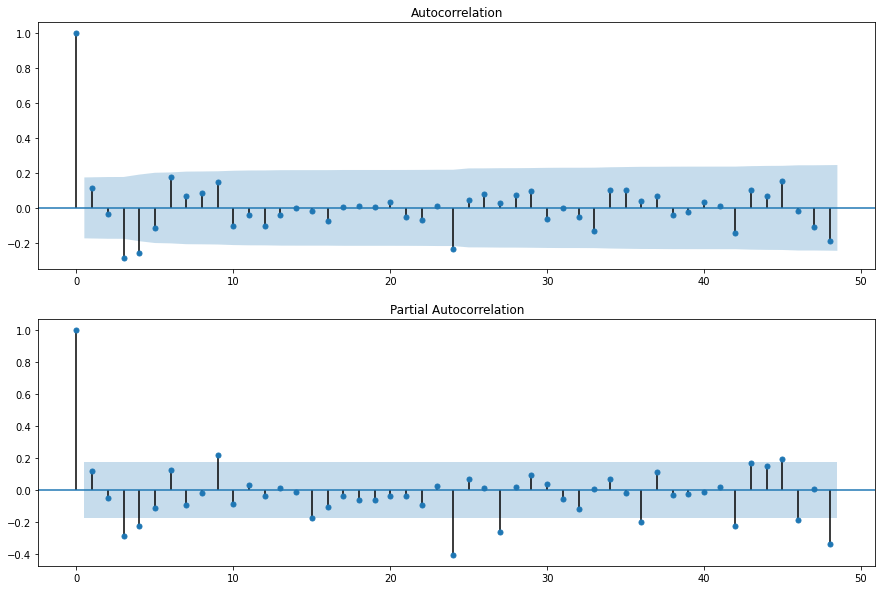

In [ ]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.data_box_season_diff[25:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.data_box_season_diff[25:].values.squeeze(), lags=48, ax=ax)

начальные приближения:
Q = 1, P = 1, q = 3, p = 4

In [ ]:
ps = range(0, 5)
d = 1
qs = range(0, 4)
Ps = range(0, 2)
D = 1
Qs = range(0, 1)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

40

подбираем параметры

In [ ]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    try:
      model=sm.tsa.statespace.SARIMAX(train_df.data_box, 
      order=(param[0], d, param[1]),
      seasonal_order=(param[3], D, param[3], 24),).fit(disp=-1)
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 40/40 [00:32<00:00,  1.21it/s]

CPU times: user 36.9 s, sys: 27.5 s, total: 1min 4s
Wall time: 32.9 s


In [ ]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
result_tableS = result_table1.sort_values(by = 'aic', ascending=True)
print(result_table1.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
21  (2, 2, 1, 0)  2849.520685
20  (2, 2, 0, 0)  2849.520685
28  (3, 2, 0, 0)  2850.285492
29  (3, 2, 1, 0)  2850.285492
33  (4, 0, 1, 0)  2850.304969


Выбираем параметры с наименьшим aic и строим модель 

In [ ]:
best_model=sm.tsa.statespace.SARIMAX(train_df.data_box, order=(2, d, 2), 
                                        seasonal_order=(1, D, 0, 24)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           data_box   No. Observations:                  151
Model:             SARIMAX(2, 1, 2)x(1, 1, 0, 24)   Log Likelihood               -1416.913
Date:                            Tue, 23 Mar 2021   AIC                           2845.825
Time:                                    01:09:00   BIC                           2862.843
Sample:                                         0   HQIC                          2852.739
                                            - 151                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1194      0.191      5.857      0.000       0.745       1.494
ar.L2         -0.7617      0.178   

построим прогноз по получившейся модели

In [ ]:
df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(
    best_model.predict(start=train_df.shape[0], end=train_df.shape[0] + 100), lmbda
)

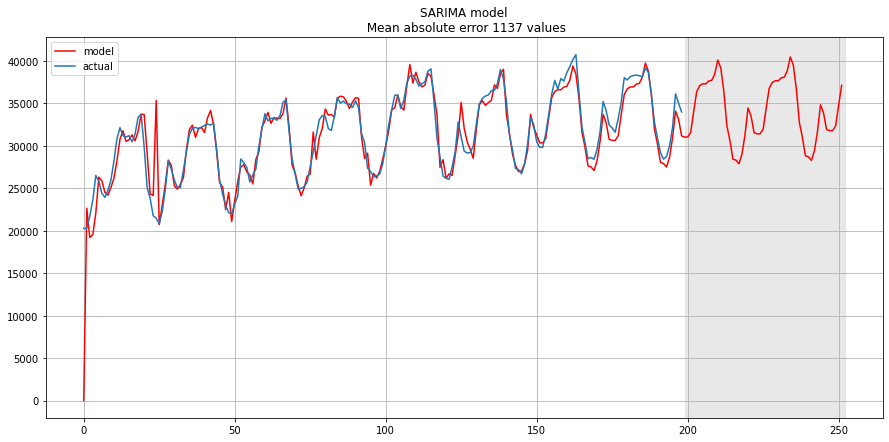

In [ ]:

df["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(
    best_model.predict(start=train_df.shape[0], end=train_df.shape[0] + 100), lmbda
)
forecast = df.arima_model.dropna().append(forecast).values[-500:]
actual = df.data.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color="r", label="model")
plt.title(
    "SARIMA model\n Mean absolute error {} values".format(
        round(mean_absolute_error(df.dropna().data, df.dropna().arima_model))
    )
)
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color="lightgrey")
plt.grid(True)

Вывод: мы получили прогноз, ошибка составила в среднем 1100. Предсказание идет от 150 до 250 - можно сравнить предсказание с реальными данными на участке от 150 до 200.